# OpenGOSim

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, beta, uniform
import pickle
import umbridge
from pymlmc.pymlmc import *
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Inputs:

| Variable  | Dimension    | Description |
|----------|-------------|-------------|
| POROSITY|		12 | Distribution below and permeability  is derived directly from this |
| PERMZ   |		1  | PERMZ is normally a fraction of PERMX. 
|         |        | Varies between 1 to 0.01, being the most probable value 0.1.|
| FAULT  |		2  | One parameter per fault. 
|         |        | It should vary between 1 (open) to 0 (completely closed) |


|   |            |   |
|----------|-------------|------|
| POROSITY RANGE:|		0.039 |	0.366  |	
| POROSITY MEAN: |		0.2	  |        |	
| POROSITY STD:  |		0.079 |        |


So we have 12 porosities, 2 faults, and 1 PERMZ scaling. Totalling 15 parameters to explore.


### Prior distributions:

Let $ \boldsymbol{\theta} \in \mathbb{R}^{16} $
1. Porosity $ \phi(\mathbf{x}) \sim \mathcal{N}_{[0.039, 0.366]}(\mu=0.2, \sigma=0.079) $
2. Permeability ratio (PERMZ) $\sim \text{Beta}_{[0.01, 1]}(\alpha=2, \beta=18) $
3. Fault $\sim \text{Uniform}(0.01, 1) $

with joint prior distribution $  \pi(\boldsymbol{\theta})$.


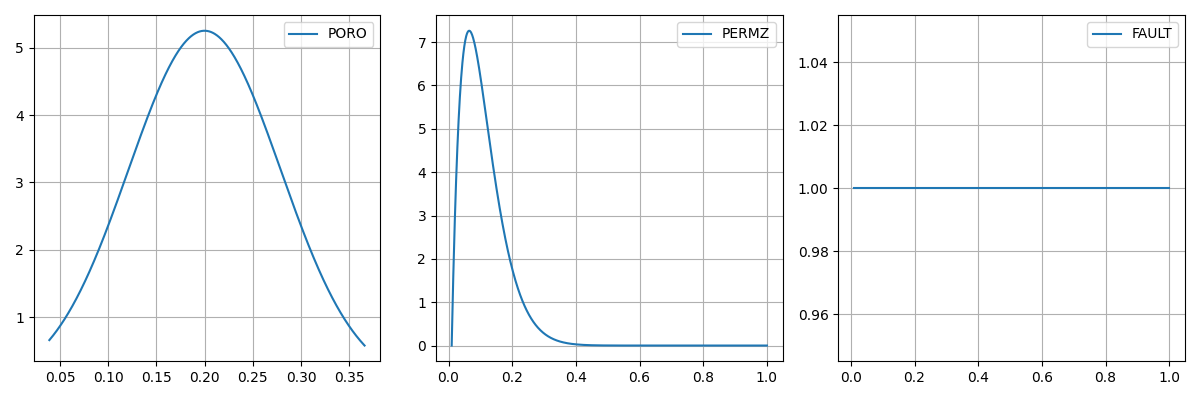

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs = axs.flatten()

mu = 0.2
sigma = 0.079
lower, upper = 0.039, 0.366
a, b = (lower - mu) / sigma, (upper - mu) / sigma
x_poro = np.linspace(lower, upper, 1000)
pdf_poro = truncnorm.pdf(x_poro, a, b, loc=mu, scale=sigma) # truncated normal
axs[0].plot(x_poro, pdf_poro, label='PORO')

alpha_pz, beta_pz = 2, 18
x_permz = np.linspace(0.01, 1, 1000)
pdf_permz = beta.pdf((x_permz - 0.01) / (1 - 0.01), alpha_pz, beta_pz) / (1 - 0.01)
axs[1].plot(x_permz, pdf_permz, label='PERMZ')

x_fault = np.linspace(0.01, 1, 1000)
pdf_fault = uniform.pdf(x_fault, loc=0.01, scale=1.0)
axs[2].plot(x_fault, pdf_fault, label='FAULT')

for i in range(3):
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### Outputs
The fields you want to analyse within the -mas.dat/CSV file are the following:
- Field fgit [m^3] : this is the accumulated CO2 injected into the model. The last value of the column is the total injected, you want to inject as much as possible.

The injected gas is scaled by `1e8` to preserve numerical precision.

**We only care about injected gas for now and ignore other outputs**


### More on permeability

A correlation between porosity and permeability is used to generate the permeability field using the following formula:

$perm = a b^{poro c -d}$

Potential values for constants:
1. $K = 10^{(15.6 poro - 0.9)}$
2. $K = 0.003 e^{(49 poro)}$

Note that the permeability obtained with these parameters is in mD which is not S.I. units (1 mD = 9.869233e-16 m^2). The permeability is a tensor, not a scalar. Normally, only the three diagonal components are considered and the Kx = Ky and Kz is considered to be a fraction of the others using the kv/kh ratio (vertical/horizontal permeability ratio). Thus, 

$K_z = c K_x$, where $0.01\leq c \leq 0.1$.

### Model

We want to simulate the process of CO2 injection through a porous
medium. Darcy’s Law governs the flow equation.


PFLOTRAN solves the steady-state Darcy flow equation:

$$\nabla \cdot \left( \mathbf{K}(\mathbf{x}, \boldsymbol{\theta}) \nabla p(\mathbf{x}) \right) = q(\mathbf{x})$$

where:
- $\mathbf{x} \in \Omega $: spatial domain
-  $p(\mathbf{x})$: pressure
- $\mathbf{K}(\mathbf{x}, \boldsymbol{\theta})$: uncertain permeability tensor
- $q(\mathbf{x})$: source/sink term



y=M(θ)


M is the PFLOTRAN simulation and y are quantities of interest

- Darcy: https://docs.opengosim.com/theory/mathematical_formulation_of_gw/
- Wells: https://docs.opengosim.com/theory/well_model/

The UM-Bridge server assumes pflotran root directory is `/pflotran_ogs_1.8/`. Please check your local installation.

In [14]:
model = umbridge.HTTPModel("http://localhost:4243", "pflotran_simulation")

n_inputs = model.get_input_sizes()[0]
n_outputs = model.get_output_sizes()[0]

print("Number of inputs ", n_inputs)
print("Number of outputs ", n_outputs)

Number of inputs  15
Number of outputs  1


### MLMC

We'll be using a modified version of the following mlmc code: <https://bitbucket.org/pefarrell/pymlmc/src/master/>.

The main algorithm is contained in `mlmc.py` but we'll use the helper function `mlmc_test.py` to perform a first round of evaluation (convergence test) to estimate convergence exponents. It calls the main MLMC function after the convergence test.

Some mlmc parameter definitions:
- `Lmin`: Minimum number of levels for the algorithm. Must be >= 2
- `Lmax`: Maximum number of levels for the algorithm. Must be >= `Lmin`
- `L`: Number of levels to use in the convergence test. Note that this is zero-indexed.
- `N`: Number of samples to evaluate in the convergence test.
- `N0`: Number of inital samples to evaluate in the main MLMC algorithm.
- `eps`: A list of error tolerance to determine algorithm convergence.

We use a Gaussian Process (GP) surrogate for `l = 0`, coarse grid for `l = 1`, and fine grid for `l = 2`.

The intermediate samples are saved in `/output/` directory with subdirectories `gp`, `pflotran/coarse`, and `pflotran/fine` for each level. Change them at `mlmc_server.py` if you wish.

Note: parallel model evaluation is possible by changing the `worker` variable in `mlmc_fn.py` but this is only tested with the load balancer framework.

In [ ]:
# First define the problem class to be wrapped around by mlmc_fn
class PFLOTRANProblem:
    def __init__(self, l, url, model_name):
        self.model = umbridge.HTTPModel(url, model_name)
        self.l = l
        
    def evaluate(self, parameters, iteration):
        config = {'l': self.l, 'iteration': iteration}
        parameters = parameters.tolist()
        outputs = self.model(parameters, config)
        return outputs[0][0]

# Define sampler function to be used by mlmc algorithm
def sampler(N,l):
    samples = np.random.random_sample((N, n_inputs))
    
    mean = 0.2
    std = 0.079
    lower, upper = 0.039, 0.366
    a, b = (lower - mean) / std, (upper - mean) / std
    
    # Porosisities
    porosity_samples = truncnorm.ppf(samples[:, :12], a, b,  loc=mean, scale=std)
    samples[:, :12] = porosity_samples

    # PERMZ scaling
    alpha, beta_param = 2, 18
    permz_scaled = beta.ppf(samples[:,12], a=alpha, b=beta_param)
    permz_scaled = 0.01 + permz_scaled * (1 - 0.01)
    samples[:, 12] = permz_scaled

    # FAULTS
    samples[:,13] = (1.0 - 0.01) * samples[:,13] + 0.01
    samples[:,14] = (1.0 - 0.01) * samples[:,14] + 0.01
    
    return (samples, samples)    

# Set various mlmc parameters
dim = n_inputs
Lmin = 2
Lmax = 3 # Set to 2 if don't want fine_model
L = 2 # Set to 1 if don't want fine_model
N = 2
N0 = 2
eps = [1] # Can add more e.g. 0.1, 0.001 if you want more accuracy

# Instantiate problem class
problems = [PFLOTRANProblem(l, "http://localhost:4243", "pflotran_simulation") for l in range(Lmax)]

# Define wrapper function for each level using mlmc_fn
def pflotran_l(l, N):
    return mlmc_fn(l, N, problems, sampler=sampler)


# Begins mlmc algorithm and call to umbridge server
logfile = open("mlmc_test.txt", 'a')
mlmc_test(pflotran_l, N, L, N0, eps, Lmin, Lmax, logfile)



**********************************************************
*** MLMC file version 0.9     produced by              ***
*** Python mlmc_test on 11-July-2025 17:12:13           ***
**********************************************************

**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
*** using N =      2 samples                           ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)  var(Pf)   kurtosis    check     cost
-------------------------------------------------------------------------------
 0   8.0468e+00  8.0468e+00  3.101e-03  3.101e-03  0.00e+00  0.00e+00  2.21e-01 
 1   5.5000e-02  8.0258e+00  1.488e-03  1.000e-10  1.00e+00  3.80e-01  5.70e+01 
 2   3.0825e-02  8.0074e+00  9.502e-04  3.380e-04  1.00e+00  4.71e-01  7.91e+02 

******************************************************
*** Linear regression estimates of MLMC parameters ***
************

Above cell should take roughly 30 minutes to finish (with 16 cores AMD EPYC 7702 and 24GB of ram). The logs are also saved in `mlmc_test.txt`. 

That's all for the MLMC part.

## Appendix

### Gaussian Process surrogate

The GP surogate is pre-trained with samples generated using DigitalNetB2 from `qmcpy`. There are about 2000 samples in the training set.

Inputs are given in `opengosim_in.pkl` and outputs are given in `opengosim_out.pkl`.

The GP model along with input/output scalers are also pickled in `opengosim_gp.pkl`, `opengosim_xscaler.pkl`, and `opengosim_yscaler.pkl` respectively.

We'll just train a separate GP and showcase the accuracy.

In [ ]:
# Assumes you cloned the benchmarks repo
with open('../../models/resevoirsim/opengosim_in.pkl', 'rb') as f:
    samples = pickle.load(f)
with open('../../models/resevoirsim/opengosim_out.pkl', 'rb') as f:
    feval = pickle.load(f)

samples = np.array(samples)
feval = np.array(feval)[:, 0].reshape(-1, 1)

samples = StandardScaler().fit_transform(samples)
feval = MinMaxScaler().fit_transform(feval)

xtrain, xtest, ytrain, ytest = train_test_split(samples, feval, test_size=0.3, random_state=1)


kernel = 1.0 * RBF(length_scale=[1.0 for i in range(dim)])
GP = GaussianProcessRegressor(kernel, n_restarts_optimizer=2)
GP.fit(xtrain, ytrain)

GP.score(xtest, ytest)

-0.03304214760556112